## `Import Libraries`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

# others
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
# mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## `Data Loading - Label Checking`


In [2]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read image at {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def load_dataset(image_dir, csv_path, target_size=(224, 224)):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['filename'])
        image = load_image(img_path)
        if image is not None:
            # Resize gambar ke ukuran target
            image = cv2.resize(image, target_size)
            images.append(image)
            labels.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])

    images = np.array(images)
    labels = np.array(labels, dtype=np.float32)
    return preprocess_dataset(images, labels, target_size)

def preprocess_image(image, target_size=(224, 224)):
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

def preprocess_dataset(images, labels, target_size=(224, 224)):
    preprocessed_images = images.astype('float32') / 255.0
    normalized_labels = labels / np.array([target_size[1], target_size[0], target_size[1], target_size[0]])
    return preprocessed_images, normalized_labels

def draw_bounding_box(image, bbox):
    xmin, ymin, xmax, ymax = map(int, bbox)  # Pastikan koordinat adalah integer
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return image

In [3]:
# Path ke folder images dan file CSV di Google Drive
# Sesuaikan jalur ini dengan struktur folder Anda di Google Drive
train_image_dir = '/content/drive/My Drive/data/train'
train_csv_path = '/content/drive/My Drive/data/train/_annotations.csv'

valid_image_dir = '/content/drive/My Drive/data/valid'
valid_csv_path = '/content/drive/My Drive/data/valid/_annotations.csv'

test_image_dir = '/content/drive/My Drive/data/test'
test_csv_path = '/content/drive/My Drive/data/test/_annotations.csv'

# Muat dataset
X_train, y_train = load_dataset(train_image_dir, train_csv_path)
X_val, y_val = load_dataset(valid_image_dir, valid_csv_path)
X_test, y_test = load_dataset(test_image_dir, test_csv_path)

## `Model Achitecture`

In [4]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [5]:
def create_model(learning_rate, optimizer_name):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='linear')  # Output 4 koordinat bounding box
    ])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'nadam':
        optimizer = Nadam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# panggil object
learning_rate = 0.001
optimizer_name = 'adam'
model = create_model(learning_rate, optimizer_name)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [6]:
# buat object Callbacks
early_stopping = EarlyStopping(patience=5,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(factor=0.2,
                              patience=5,
                              min_lr=0.00001)

checkpoint_path = '/content/drive/My Drive/data'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_mae',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')

## `Train Model`

In [7]:
# Train model
%%time
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/20
55/55 [==============================] - 30s 408ms/step - loss: 5.8309 - mae: 1.3839 - val_loss: 1.0990 - val_mae: 0.7916 - lr: 0.0010
Epoch 2/20
55/55 [==============================] - 23s 405ms/step - loss: 1.5595 - mae: 0.9630 - val_loss: 0.7819 - val_mae: 0.6785 - lr: 0.0010
Epoch 3/20
55/55 [==============================] - 24s 436ms/step - loss: 1.4307 - mae: 0.9300 - val_loss: 0.8081 - val_mae: 0.6828 - lr: 0.0010
Epoch 4/20
55/55 [==============================] - 21s 376ms/step - loss: 1.3483 - mae: 0.8925 - val_loss: 0.7688 - val_mae: 0.6694 - lr: 0.0010
Epoch 5/20
55/55 [==============================] - 22s 398ms/step - loss: 1.3171 - mae: 0.8884 - val_loss: 0.7737 - val_mae: 0.6668 - lr: 0.0010
Epoch 6/20
55/55 [==============================] - 31s 541ms/step - loss: 1.3022 - mae: 0.8718 - val_loss: 0.8540 - val_mae: 0.6892 - lr: 0.0010
Epoch 7/20
55/55 [==============================] - 20s 372ms/step - loss: 1.3548 - mae: 0.8949 - val_loss: 0.8803 - val_mae

In [8]:
# Load model terbaik setelah training
model.load_weights(checkpoint_path)
model.save('/content/drive/My Drive/data/keras_model.h5')

## `Evaluate Model`

In [9]:
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1p, y1p, x2p, y2p = box2

    xi1 = max(x1, x1p)
    yi1 = max(y1, y1p)
    xi2 = min(x2, x2p)
    yi2 = min(y2, y2p)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2p - x1p) * (y2p - y1p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def calculate_map(y_true, y_pred, iou_threshold=0.5):
    precisions = []
    recalls = []
    for threshold in np.arange(0.5, 1.0, 0.05):
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(y_true)):
            iou = calculate_iou(y_true[i], y_pred[i])
            if iou >= threshold:
                tp += 1
            else:
                fp += 1
                fn += 1
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

# Prediksi menggunakan model
y_pred = model.predict(X_val)

# Hitung IoU
ious = [calculate_iou(y_val[i], y_pred[i]) for i in range(len(y_val))]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

# Hitung mAP
precision, recall = calculate_map(y_val, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

17/17 [==============================] - 0s 20ms/step
Mean IoU: 0.0343
Precision: 0.0012
Recall: 0.0012


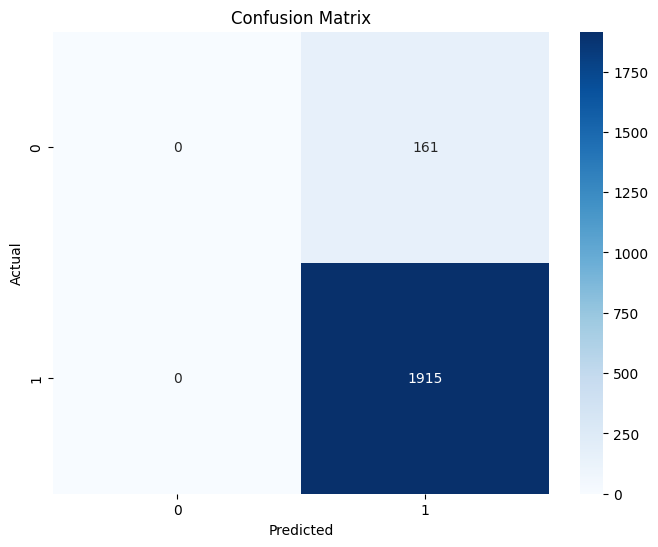

In [10]:
# Plot Confusion Matrix
y_true_classes = (y_val > 0.5).astype(int).flatten()
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

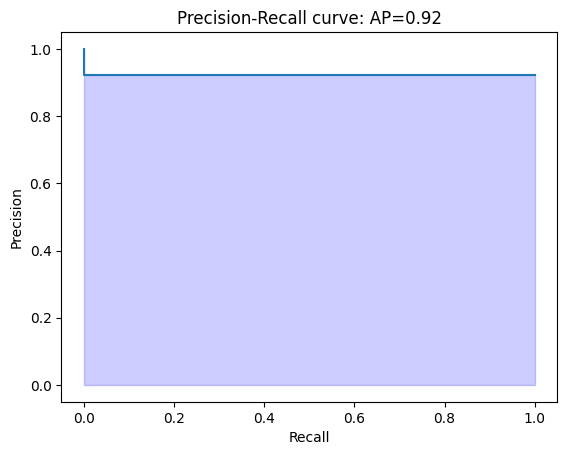

In [11]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_classes)
average_precision = average_precision_score(y_true_classes, y_pred_classes)

plt.figure()
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()

## `Hyperparameter Tuning`

In [12]:
# Hyperparameter tuning

%%time
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
optimizers = ['adam', 'nadam']

best_accuracy = 0
best_params = {}

for optimizer_name in optimizers:
    for lr in learning_rates:
        for bs in batch_sizes:
            model = create_model(learning_rate=lr, optimizer_name=optimizer_name)
            history = model.fit(
                datagen.flow(X_train, y_train, batch_size=bs),
                epochs=10,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )

            val_accuracy = history.history['val_mae'][-1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'optimizer': optimizer_name, 'learning_rate': lr, 'batch_size': bs}

print("Best parameters:", best_params)
print("Best validation accuracy:", best_accuracy)

Best parameters: {'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64}
Best validation accuracy: 0.9382212162017822
CPU times: user 27min 44s, sys: 58.8 s, total: 28min 42s
Wall time: 33min 35s


## `Retrain with Best Parameter`

In [21]:
import tensorflow as tf
# Retrain model with best parameters

learning_rate = 0.01
optimizer_name = 'adam'
batch_size = 64

# Create the model
final_model = create_model(learning_rate=learning_rate, optimizer_name=optimizer_name)

# Initialize the optimizer
if optimizer_name == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer_name == 'nadam':
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
# Add other optimizers as needed

# Compile the model with the optimizer and loss function
final_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

final_history = final_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
28/28 [==============================] - 25s 843ms/step - loss: 1966.4790 - mae: 3.9181 - val_loss: 1.0154 - val_mae: 0.7547 - lr: 0.0100
Epoch 2/20
28/28 [==============================] - 21s 748ms/step - loss: 1.1988 - mae: 0.8437 - val_loss: 0.7580 - val_mae: 0.6642 - lr: 0.0100
Epoch 3/20
28/28 [==============================] - 22s 790ms/step - loss: 1.2045 - mae: 0.8490 - val_loss: 0.9275 - val_mae: 0.7167 - lr: 0.0100
Epoch 4/20
28/28 [==============================] - 21s 748ms/step - loss: 1.1147 - mae: 0.8137 - val_loss: 0.7470 - val_mae: 0.6601 - lr: 0.0100
Epoch 5/20
28/28 [==============================] - 23s 856ms/step - loss: 1.0926 - mae: 0.8082 - val_loss: 0.7334 - val_mae: 0.6565 - lr: 0.0100
Epoch 6/20
28/28 [==============================] - 23s 828ms/step - loss: 1.1056 - mae: 0.8110 - val_loss: 0.8570 - val_mae: 0.6887 - lr: 0.0100
Epoch 7/20
28/28 [==============================] - 21s 764ms/step - loss: 1.0900 - mae: 0.8038 - val_loss: 0.7351 - val_

In [22]:
# Load model terbaik setelah training
final_model.load_weights(checkpoint_path)
final_model.save('/content/drive/My Drive/data/tuned_keras.h5')

## `Evaluate Final Model`

In [23]:
# Evaluate final model
y_pred = final_model.predict(X_val)

# Hitung IoU
ious = [calculate_iou(y_val[i], y_pred[i]) for i in range(len(y_val))]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

# Hitung mAP
precision, recall = calculate_map(y_val, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

17/17 [==============================] - 0s 20ms/step
Mean IoU: 0.0343
Precision: 0.0012
Recall: 0.0012


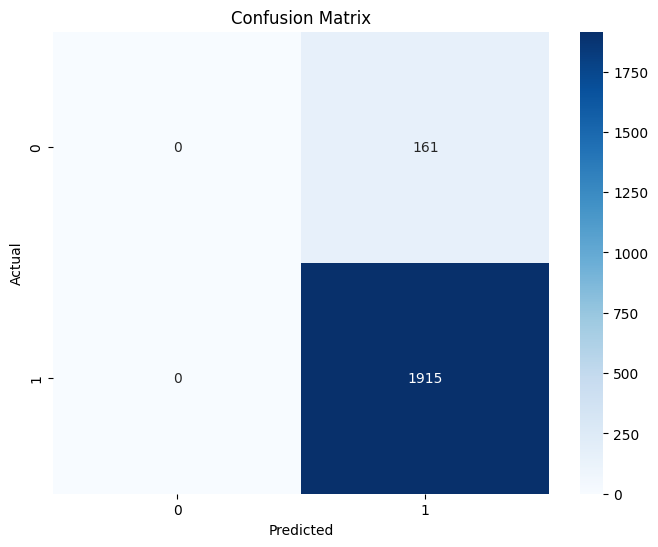

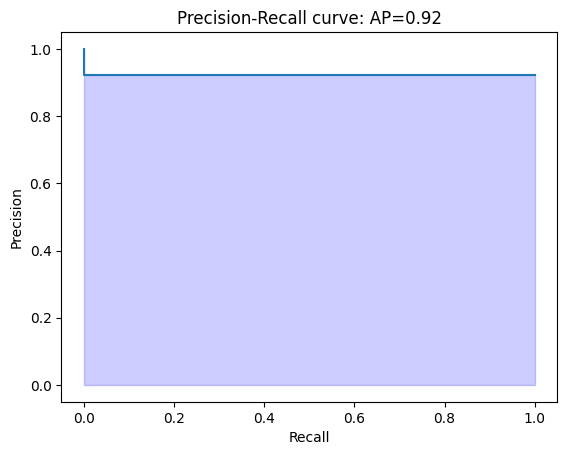

In [24]:
# Plot Confusion Matrix
y_true_classes = (y_val > 0.5).astype(int).flatten()
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_classes)
average_precision = average_precision_score(y_true_classes, y_pred_classes)

plt.figure()
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()

In [25]:
def visualize_predictions(model, X_test, y_test, num_images=10):
    predictions = model.predict(X_test[:num_images])

    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5*num_images))
    for i in range(num_images):
        img_true = (X_test[i] * 255).astype(np.uint8)
        img_true = draw_bounding_box(img_true, y_test[i] * np.array([224, 224, 224, 224]))
        axes[i, 0].imshow(img_true)
        axes[i, 0].set_title('Ground Truth')
        axes[i, 0].axis('off')

        img_pred = (X_test[i] * 255).astype(np.uint8)
        img_pred = draw_bounding_box(img_pred, predictions[i] * np.array([224, 224, 224, 224]))
        axes[i, 1].imshow(img_pred)
        axes[i, 1].set_title('Prediction')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# Visualisasi prediksi
visualize_predictions(final_model, X_test, y_test)

Output hidden; open in https://colab.research.google.com to view.